<a href="https://colab.research.google.com/github/KhuzaimahAziz/Product_Review_Bot/blob/main/Product_review_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import itertools
import six
import tensorflow as tf
import time
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Using Restaurant Reviews for our Language Model

In [5]:
df_2=pd.read_csv('/content/drive/MyDrive/Restaurant_Reviews.tsv',delimiter='\t')

In [6]:
df_2

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


## Data Cleaning. Cleaning Text by removing punctuations.

In [7]:
def text_clean(string2):
  strng=str(string2)
  strng=re.sub(r'([,.!?])', r' \1', strng)
  strng=re.sub('[^a-zA-Z1-9]+', ' ', strng)
  strng = re.sub(r'\d+', '',strng)
  return strng.lower().strip()


In [8]:
df_2['Clean_Review']=df_2['Review'].apply(text_clean)

In [9]:
clean=df_2['Clean_Review'].iloc[:300].astype(str).values.tolist()

In [10]:
clean

['wow loved this place',
 'crust is not good',
 'not tasty and the texture was just nasty',
 'stopped by during the late may bank holiday off rick steve recommendation and loved it',
 'the selection on the menu was great and so were the prices',
 'now i am getting angry and i want my damn pho',
 'honeslty it didn t taste that fresh',
 'the potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer',
 'the fries were great too',
 'a great touch',
 'service was very prompt',
 'would not go back',
 'the cashier had no care what so ever on what i had to say it still ended up being wayyy overpriced',
 'i tried the cape cod ravoli chicken with cranberry mmmm',
 'i was disgusted because i was pretty sure that was human hair',
 'i was shocked because no signs indicate cash only',
 'highly recommended',
 'waitress was a little slow in service',
 'this place is not worth your time let alone vegas',
 'did not like at all',
 'the burrittos blah',
 't

## Converting Text into Tokens

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean)

In [12]:
input_sequences = []

for review in clean:
	token_list = tokenizer.texts_to_sequences([review])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow.keras.utils as ku

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
total_words = len(tokenizer.word_index) + 1
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

## Model Architecture Using LSTM (Sequence-to-Sequence)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the Model

I trained model on 300 reviews only as it took alot of time to train it on whole data.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy')>0.90):
			print("\nReached 90% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[callbacks], steps_per_epoch=20)

Epoch 1/300
20/20 [==============================] - 21s 627ms/step - loss: 7.8578 - accuracy: 0.0395
Epoch 2/300
20/20 [==============================] - 10s 481ms/step - loss: 6.7965 - accuracy: 0.0372
Epoch 3/300
20/20 [==============================] - 12s 623ms/step - loss: 6.4425 - accuracy: 0.0385
Epoch 4/300
20/20 [==============================] - 14s 712ms/step - loss: 6.2160 - accuracy: 0.0430
Epoch 5/300
20/20 [==============================] - 12s 627ms/step - loss: 5.9901 - accuracy: 0.0376
Epoch 6/300
20/20 [==============================] - 10s 494ms/step - loss: 5.8568 - accuracy: 0.0420
Epoch 7/300
20/20 [==============================] - 12s 599ms/step - loss: 5.7573 - accuracy: 0.0481
Epoch 8/300
20/20 [==============================] - 12s 632ms/step - loss: 5.6574 - accuracy: 0.0430
Epoch 9/300
20/20 [==============================] - 12s 598ms/step - loss: 5.5755 - accuracy: 0.0513
Epoch 10/300
20/20 [==============================] - 10s 499ms/step - loss: 5.501

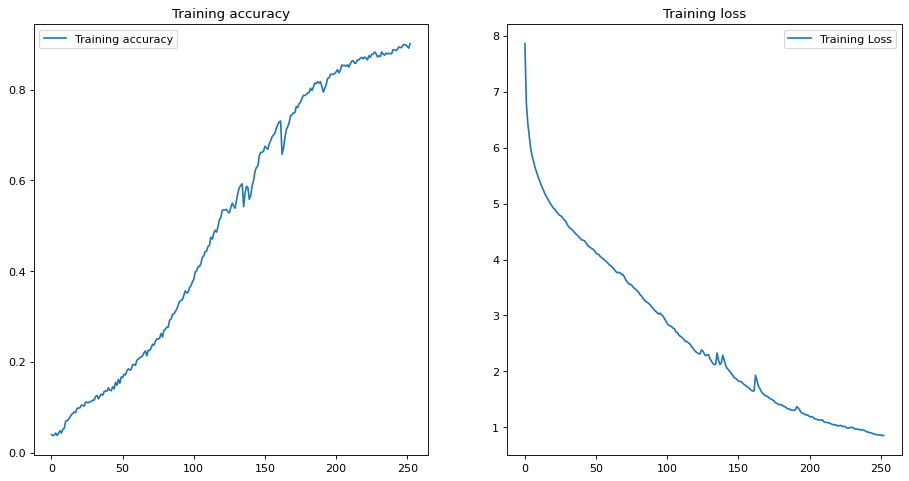

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

figure(figsize=(14, 7), dpi=80)

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
def predict(seed_text, next_words, max_sequence_len, model):
  for _ in range(next_words):
    token_list=tokenizer.texts_to_sequences([seed_text])[0]
    token_list=pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted=np.argmax(model.predict(token_list), axis=1)
    output_word=""
    for word, index in tokenizer.word_index.items():
      if index== predicted:
        output_word=word
        break
    seed_text +=" "+ output_word
  
  seed_text=(seed_text+".").capitalize()
  print(seed_text)
  return seed_text

## Predicting Reviews

Results can be improved given more data and deep NN architecture.

In [ ]:
review_df=['The meat was bad','The food was  ','He was', "I decided", 'wait was too long', 'avoid this ']

In [ ]:
for i in review_df:
  predict(i, 10, max_sequence_len, model)

1/1 [==============================] - 0s 56ms/step
The meat was bad the other rolls had quantity dishes taste how they m.
1/1 [==============================] - 0s 37ms/step
The food was   delicious our bartender was attentive and personable and we got.
1/1 [==============================] - 0s 32ms/step
He was extremely rude and really there are so many other restaurants.
1/1 [==============================] - 0s 37ms/step
I decided it here because that is terrific and reasonably priced when.
1/1 [==============================] - 0s 36ms/step
Wait was too long good rice in the egg rolls were delicious flavorful delights.
1/1 [==============================] - 0s 33ms/step
Avoid this  is the burger was overcooked and bad it and a.
